In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination

In [20]:
df = pd.read_excel('各参数SEA+h1h2.xlsx')

In [21]:
df.head()

,α(°),β(°),l1/l2,t_mm,SEA,F1,F2,Δh1(mm),Δh2(mm),Δh1(mm)+Δh2(mm),mkg)
0,30,45,1.5,1.0,509.47,0.516,2.326,42.426407,3.63961,46.066017,0.143153
1,30,45,1.5,1.1,723.12,0.770,3.652,42.426407,3.63961,46.066017,0.157469
2,30,45,1.5,1.2,789.33,0.889,5.373,42.426407,3.63961,46.066017,0.171784
3,30,45,1.5,1.3,811.65,1.220,6.432,42.426407,3.63961,46.066017,0.186099
4,30,45,2.0,1.0,475.90,0.682,1.590,31.819805,18.63961,50.459415,0.124388


In [22]:
print(df.shape)
print(df.columns)
print([x for x in df.columns if x not in ['SEA', 'Δh1(mm)', 'Δh2(mm)', 'Δh1(mm)+Δh2(mm)',]])

(560, 11)
Index(['α(°)', 'β(°)', 'l1/l2', 't_mm', 'SEA', 'F1', 'F2', 'Δh1(mm)',
       'Δh2(mm)', 'Δh1(mm)+Δh2(mm)', 'mkg)'],
      dtype='object')
['α(°)', 'β(°)', 'l1/l2', 't_mm', 'F1', 'F2', 'mkg)']


In [23]:
input_cols = [x for x in df.columns if x not in ['SEA', 'Δh1(mm)', 'Δh2(mm)', 'Δh1(mm)+Δh2(mm)',]]
target_cols = ['SEA', 'Δh1(mm)+Δh2(mm)',]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(df[input_cols]),
    np.array(df[target_cols]),
    test_size=0.4,
    shuffle=True,
    random_state=42,
)

X_CV, X_test, y_CV, y_test = train_test_split(
    X_test,
    y_test,
    test_size=0.5,
    shuffle=True,
    random_state=42,
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_CV.shape, y_CV.shape)

(336, 7) (336, 2)
(112, 7) (112, 2)
(112, 7) (112, 2)


In [25]:
X_train_scaler = StandardScaler()
X_train_scaled = X_train_scaler.fit_transform(X_train)
X_CV_scaled = X_train_scaler.transform(X_CV)
X_test_scaled = X_train_scaler.transform(X_test)

y_train_scaler = StandardScaler()
y_train_scaled = y_train_scaler.fit_transform(y_train)
y_CV_scaled = y_train_scaler.transform(y_CV)
y_test_scaled = y_train_scaler.transform(y_test)

In [26]:
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models = [None] * len(lambdas)
for i in range(len(lambdas)):
    models[i] = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(7,)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambdas[i]),),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambdas[i]),),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambdas[i]),),
    tf.keras.layers.Dense(2, activation='linear'),
])

    models[i].compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
)

    history = models[i].fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    verbose=0
)
    print(f"{i} completed training")

0 completed training
1 completed training
2 completed training
3 completed training
4 completed training
5 completed training
6 completed training


In [27]:
y_train_pred_mses = []
y_CV_pred_mses = []

for i in range(len(lambdas)):
    y_train_pred = models[i].predict(X_train_scaled)
    y_train_pred_mse = mean_squared_error(y_train_scaled, y_train_pred)
    y_train_pred_mses.append(y_train_pred_mse)

    y_CV_pred = models[i].predict(X_CV_scaled)
    y_CV_pred_mse = mean_squared_error(y_CV_scaled, y_CV_pred)
    y_CV_pred_mses.append(y_CV_pred_mse)

print(y_train_pred_mses)
print(y_CV_pred_mses)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[0.004764532416694563, 0.008812719224159339, 0.018716167747164763, 0.04225139640647928, 0.07986131970792115, 0.10945485022050383, 0.1487170476940177]
[0.01682564882195883, 0.015361531935160284, 0.021261256729905392, 0.04654342472168052, 0.08062758548570509, 0.11163846617748155, 0.15759902549742938]


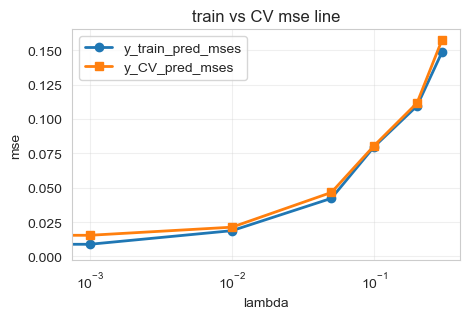

In [28]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(lambdas, y_train_pred_mses, marker='o', label='y_train_pred_mses', linewidth=2, markersize=6)
ax.plot(lambdas, y_CV_pred_mses, marker='s', label='y_CV_pred_mses', linewidth=2, markersize=6)

ax.set_xlabel('lambda')
ax.set_ylabel('mse')
ax.set_xscale('log')
ax.set_title('train vs CV mse line')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

In [29]:
y_test_pred = models[2].predict(X_test_scaled)
print(y_test_pred.shape)

# rmse_test = np.sqrt(mean_squared_error(y_test, y_train_scaler.inverse_transform(y_test_pred), ))
# print(rmse_test)

r2_test = r2_score(y_test_scaled, y_test_pred)
print(r2_test)

mse_per_dim = [
    mean_squared_error(y_test[:, 0], y_train_scaler.inverse_transform(y_test_pred)[:, 0]),
    mean_squared_error(y_test[:, 1], y_train_scaler.inverse_transform(y_test_pred)[:, 1])
]
avg_rmse = np.sqrt(np.mean(mse_per_dim))
print(y_test[0])
print(mse_per_dim)
print(avg_rmse)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
(112, 2)
0.976713597225956
[666.48        66.42355147]
[759.6072443746613, 0.8750965615407339]
19.499773600431904


In [30]:
xl = df[input_cols].min().values
xu = df[input_cols].max().values

In [ ]:
class VectorizedCrashProblem(Problem):
    def __init__(self, xl, xu, model, scaler):
        super().__init__(n_var=7,
                         n_obj=2,
                         n_constr=0,
                         xl=xl,
                         xu=xu)
        self.model = model
        self.scaler = scaler

    def _evaluate(self, x, out, *args, **kwargs):

        x_scaled = self.scaler.transform(x)

        preds = y_train_scaler.inverse_transform(self.model.predict(x_scaled, verbose=0))

        sea_pred = preds[:, 0]
        deformation_pred = preds[:, 1]

        f1 = -sea_pred
        f2 = -deformation_pred

        out["F"] = np.column_stack([f1, f2])

problem = VectorizedCrashProblem(xl=xl, xu=xu, model=models[2], scaler=X_train_scaler)

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=50,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(prob=0.01, eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 200)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               verbose=True)

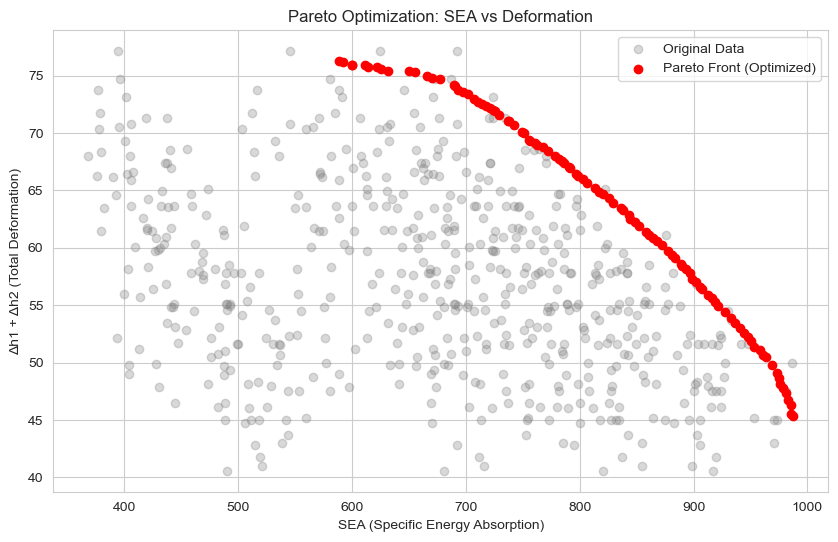

In [43]:
pareto_front_objectives = -res.F
pareto_front_variables = res.X

result_df = pd.DataFrame(pareto_front_variables, columns=input_cols)
result_df['Predicted SEA'] = pareto_front_objectives[:, 0]
result_df['Predicted h1+h2'] = pareto_front_objectives[:, 1]

result_df = result_df.sort_values(by='Predicted SEA')

plt.figure(figsize=(10, 6))
plt.scatter(df['SEA'], df['Δh1(mm)+Δh2(mm)'], color='gray', alpha=0.3, label='Original Data')
plt.scatter(result_df['Predicted SEA'], result_df['Predicted h1+h2'], color='red', label='Pareto Front (Optimized)')
plt.xlabel('SEA (Specific Energy Absorption)')
plt.ylabel('Δh1 + Δh2 (Total Deformation)')
plt.title('Pareto Optimization: SEA vs Deformation')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
result_df.to_excel("Optimization_Results_Pareto.xlsx", index=False)
print("\n优化结果已保存至 Optimization_Results_Pareto.xlsx")


优化结果已保存至 Optimization_Results_Pareto.xlsx
